In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from utils import *
from models import *

import numpy as np

torch.cuda.empty_cache()
device = torch.device("cuda:0")

In [20]:
width = 1000
style_img = read_image('s2.jpg', target_width=width).to(device)
content_img = read_image('coco/coco128/00007.jpg', target_width=width).to(device)
noise = read_image('pic/white.jpg', target_width=width).to(device)

(1000, 1000, 3)
(1000, 1000, 3)


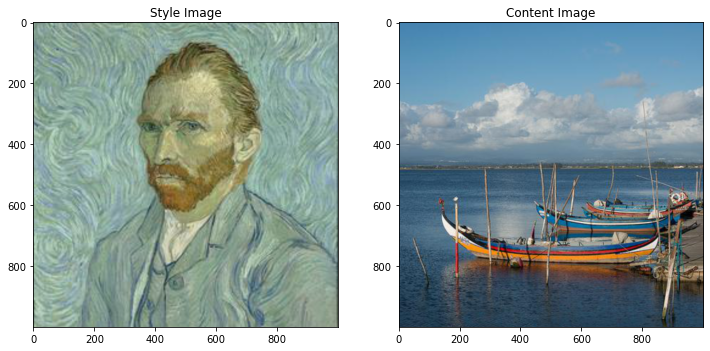

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 2, 2)
imshow(content_img, title='Content Image')

In [22]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16.features)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()
# vgg16 = VGG(vgg16.features).to(device).eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [23]:
style_features = vgg16(style_img)
content_features = vgg16(content_img)

print('content_features')
for x in content_features:
    print(x.shape)

print('style_features')
for x in style_features:
    print(x.shape)

content_features
torch.Size([1, 64, 1000, 1000])
torch.Size([1, 128, 500, 500])
torch.Size([1, 256, 250, 250])
torch.Size([1, 512, 125, 125])
style_features
torch.Size([1, 64, 1000, 1000])
torch.Size([1, 128, 500, 500])
torch.Size([1, 256, 250, 250])
torch.Size([1, 512, 125, 125])


In [24]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

style_grams = [gram_matrix(x) for x in style_features]
[x.shape for x in style_grams]

[torch.Size([1, 64, 64]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 512, 512])]

In [25]:
input_img = content_img.clone()
optimizer = optim.Adam([input_img.requires_grad_()])
style_weight = 1e7
content_weight = 1

style_loss_list = []
content_loss_list = []
loss_list = []

run = [0]
while run[0] <= 2000:
    def f():
        optimizer.zero_grad()
        features = vgg16(input_img)
        
        content_loss = F.mse_loss(features[2], content_features[2]) * content_weight
        style_loss = 0
        grams = [gram_matrix(x) for x in features]
        for a, b in zip(grams, style_grams):
            style_loss += F.mse_loss(a, b) * style_weight
        
        loss = style_loss + content_loss

        style_loss_list.append(style_loss.item())
        content_loss_list.append(content_loss.item())
        loss_list.append(loss.item())
        
        if run[0] % 50 == 0:
            print('Step {}: Style Loss: {:4f} Content Loss: {:4f}'.format(
                run[0], style_loss.item(), content_loss.item()))
        run[0] += 1
        
        loss.backward()
        return loss
    
    optimizer.step(f)

Step 0: Style Loss: 501.302917 Content Loss: 0.000000


Step 50: Style Loss: 368.179626 Content Loss: 0.843328
Step 100: Style Loss: 288.883789 Content Loss: 1.300109
Step 150: Style Loss: 217.056717 Content Loss: 1.572623
Step 200: Style Loss: 156.638123 Content Loss: 1.767959
Step 250: Style Loss: 112.624084 Content Loss: 1.921369
Step 300: Style Loss: 83.699196 Content Loss: 2.047674
Step 350: Style Loss: 65.056686 Content Loss: 2.152817
Step 400: Style Loss: 52.395397 Content Loss: 2.239695
Step 450: Style Loss: 43.238197 Content Loss: 2.312048
Step 500: Style Loss: 36.311493 Content Loss: 2.371198
Step 550: Style Loss: 30.925533 Content Loss: 2.419290
Step 600: Style Loss: 26.664705 Content Loss: 2.458432
Step 650: Style Loss: 23.255812 Content Loss: 2.490381
Step 700: Style Loss: 20.502851 Content Loss: 2.516402
Step 750: Style Loss: 18.257780 Content Loss: 2.537179
Step 800: Style Loss: 16.404861 Content Loss: 2.553646
Step 850: Style Loss: 14.858915 Content Loss: 2.566673
Step 900: Style Loss: 13.557303 Content Loss: 2.576913
Step 9

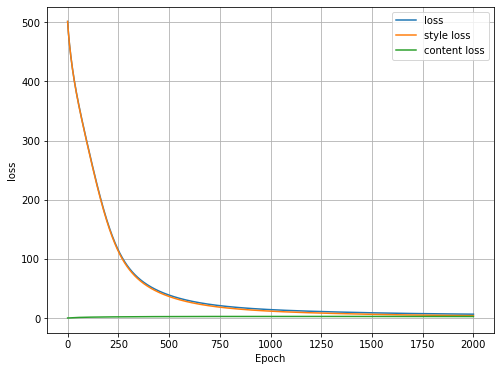

In [26]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.plot(loss_list, label='loss')
plt.plot(style_loss_list, label='style loss')
plt.plot(content_loss_list, label='content loss')


plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

plt.grid(True)
plt.show()

(1000, 1000, 3)
(1000, 1000, 3)
(1000, 1000, 3)


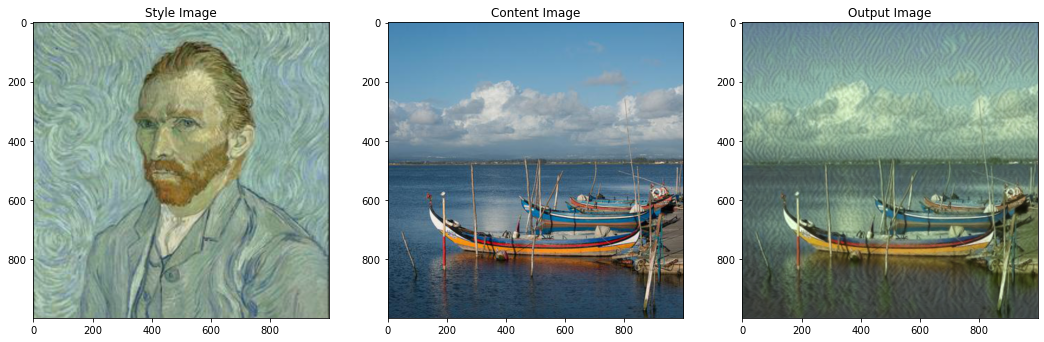

In [27]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 3, 2)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 3)
imshow(input_img, title='Output Image')
